In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

In [90]:
df = pd.read_csv('../week1.csv')
df = df[df['Ticker'] == 'AAPL']
df

,Ticker,Date,Open,High,Low,Close,Volume,Target,Close_lag_1,Close_lag_2,...,MA_30,STD_7,STD_30,Volume_lag_1,Volume_avg_7,Volume_change,30D RV,MA_ratio,HL_ratio,CO_ratio
0,AAPL,2010-06-28,34.191,34.545,33.874,34.360,163083315,-0.045227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.019809,1.004943
1,AAPL,2010-06-29,33.856,33.856,32.565,32.806,315472195,-0.018106,34.360,NaN,...,NaN,NaN,NaN,163083315.0,NaN,0.934423,NaN,NaN,1.039644,0.968986
2,AAPL,2010-06-30,32.877,33.036,32.020,32.212,205878957,-0.012076,32.806,34.360,...,NaN,NaN,NaN,315472195.0,NaN,-0.347394,NaN,NaN,1.031730,0.979773
3,AAPL,2010-07-01,32.542,32.629,31.147,31.823,285057573,-0.006285,32.212,32.806,...,NaN,NaN,NaN,205878957.0,NaN,0.384588,NaN,NaN,1.047581,0.977905
4,AAPL,2010-07-02,32.103,32.132,31.144,31.623,193495389,0.006925,31.823,32.212,...,NaN,NaN,NaN,285057573.0,NaN,-0.321206,NaN,NaN,1.031724,0.985048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,AAPL,2017-11-06,171.750,174.360,171.100,173.630,34901241,0.003168,171.880,167.510,...,158.380667,3.746112,5.951958,59612161.0,4.220188e+07,-0.414528,1.173754,1.061033,1.019053,1.010946
1855,AAPL,2017-11-07,173.290,174.510,173.290,174.180,24424877,0.008210,173.630,171.880,...,159.100333,3.442828,6.507019,34901241.0,3.932529e+07,-0.300172,1.151007,1.066748,1.007040,1.005136
1856,AAPL,2017-11-08,174.030,175.610,173.710,175.610,24451166,-0.002050,174.180,173.630,...,159.831333,3.651136,7.083385,24424877.0,3.640953e+07,0.001076,1.152021,1.070352,1.010938,1.009079
1857,AAPL,2017-11-09,174.480,175.460,172.520,175.250,29533086,-0.003310,175.610,174.180,...,160.582000,3.736420,7.486672,24451166.0,3.546048e+07,0.207840,1.141205,1.071415,1.017042,1.004413


In [91]:
df = df.dropna()
features = ['Daily Return', '30D RV', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Return_lag_1', 'Return_lag_2', 'MA_7',
       'MA_30', 'STD_7', 'STD_30', 'MA_ratio', 'HL_ratio', 'CO_ratio','Volume_lag_1', 'Volume_avg_7', 'Volume_change']
X = df[features]
y = df['Target']

split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.head())
print(y_train.head())

    Daily Return    30D RV  Close_lag_1  Close_lag_2  Close_lag_3  \
30     -0.892005  1.598099       33.520       33.307       33.513   
31     -3.554980  1.513263       33.221       33.520       33.307   
32      0.642946  1.481791       32.040       33.221       33.520   
33     -1.073001  1.478163       32.246       32.040       33.221   
34     -0.583072  1.477501       31.900       32.246       32.040   

    Return_lag_1  Return_lag_2       MA_7      MA_30     STD_7    STD_30  \
30      0.639505     -0.614687  33.473429  32.832567  0.155459  0.669400   
31     -0.892005      0.639505  33.260286  32.807033  0.559506  0.684878   
32     -3.554980     -0.892005  33.074857  32.808167  0.656491  0.683887   
33      0.642946     -3.554980  32.821000  32.810733  0.724855  0.680196   
34     -1.073001      0.642946  32.564000  32.813767  0.756828  0.674899   

    MA_ratio  HL_ratio  CO_ratio  Volume_lag_1  Volume_avg_7  Volume_change  
30  1.019519  1.011187  0.998347    84312659.0  1.

In [92]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [93]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train MAE:", train_mae)
print("Train RMSE:", train_rmse)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

Train MAE: 0.0046294987199028284
Train RMSE: 0.006470905024058119
Test MAE: 0.01131799850440578
Test RMSE: 0.014577052788234561


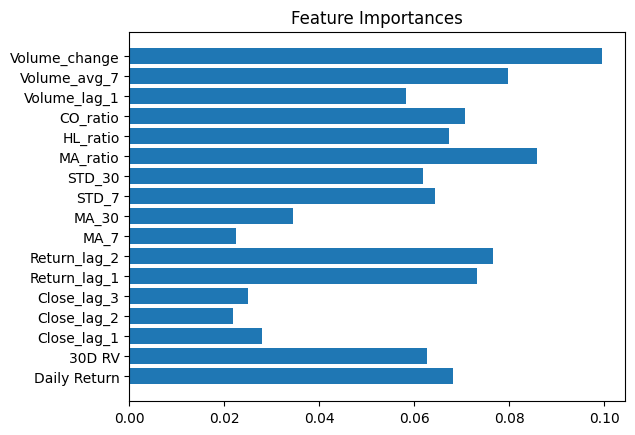

In [94]:
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title("Feature Importances")
plt.show()

In [126]:
train_close_today = df.loc[X_train.index, 'Close'].values
train_predicted_close_tomorrow = train_close_today * (1 + y_train_pred)

train_true_close_tomorrow = df.loc[y_train.index, 'Close'].shift(-1)
train_valid_indices = ~train_true_close_tomorrow.isna()

train_true_close_tomorrow = train_true_close_tomorrow[train_valid_indices].values
train_predicted_close_tomorrow = train_predicted_close_tomorrow[train_valid_indices]

train_mae_close = mean_absolute_error(train_true_close_tomorrow, train_predicted_close_tomorrow)
train_rmse_close = np.sqrt(mean_squared_error(train_true_close_tomorrow, train_predicted_close_tomorrow))

print("Close Price Prediction MAE (Train):", train_mae_close)
print("Close Price Prediction RMSE (Train):", train_rmse_close)

test_close_today = df.loc[X_test.index, 'Close'].values
test_predicted_close_tomorrow = test_close_today * (1 + y_test_pred)
test_true_close_tomorrow = df.loc[y_test.index, 'Close'].shift(-1)
valid_indices = ~test_true_close_tomorrow.isna()

test_true_close_tomorrow = test_true_close_tomorrow[valid_indices].values
test_predicted_close_tomorrow = test_predicted_close_tomorrow[valid_indices]

test_mae_close = mean_absolute_error(test_true_close_tomorrow, test_predicted_close_tomorrow)
test_rmse_close = np.sqrt(mean_squared_error(test_true_close_tomorrow, test_predicted_close_tomorrow))

print("Close Price Prediction MAE (Test):", test_mae_close)
print("Close Price Prediction RMSE (Test):", test_rmse_close)

Close Price Prediction MAE (Train): 0.3469544632870571
Close Price Prediction RMSE (Train): 0.5039566437058421
Close Price Prediction MAE (Test): 1.506048530582386
Close Price Prediction RMSE (Test): 1.9781954869261054
